In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from pointnet2_utils import PointNetSetAbstractionMsg, PointNetSetAbstraction
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os

In [2]:
class get_model(nn.Module):
    def __init__(self,num_class,normal_channel=True):
        super(get_model, self).__init__()
        in_channel = 3 if normal_channel else 0
        self.normal_channel = normal_channel
        self.sa1 = PointNetSetAbstractionMsg(512, [0.1, 0.2, 0.4], [16, 32, 128], in_channel,[[32, 32, 64], [64, 64, 128], [64, 96, 128]])
        self.sa2 = PointNetSetAbstractionMsg(128, [0.2, 0.4, 0.8], [32, 64, 128], 320,[[64, 64, 128], [128, 128, 256], [128, 128, 256]])
        self.sa3 = PointNetSetAbstraction(None, None, None, 640 + 3, [256, 512, 1024], True)
        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_class)

    def forward(self, xyz):
        B, _, _ = xyz.shape
        if self.normal_channel:
            norm = xyz[:, 3:, :]
            xyz = xyz[:, :3, :]
        else:
            norm = None
        l1_xyz, l1_points = self.sa1(xyz, norm)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        x = l3_points.view(B, 1024)
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        x = F.log_softmax(x, -1)


        return x,l3_points


class get_loss(nn.Module):
    def __init__(self):
        super(get_loss, self).__init__()

    def forward(self, pred, target, trans_feat):
        total_loss = F.nll_loss(pred, target)

        return total_loss
   

In [3]:
B = 283  # batch size
N = 1000  # number of points per sample

# Generate a random tensor of shape [B, N, 3]
input_tensor = torch.rand(B, 3, N)

In [45]:
points.shape

torch.Size([32, 1024, 3])

In [5]:
# Assuming your numpy array is named 'data'
data = np.load('3grads.npy')
labels = np.array([0] * 150 + [1] * 133)
data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

batch_size = 283
num_points = 1024
num_dimensions = 6  # 3-dimensional input per point

# Generate the random array
random_array = np.random.rand(batch_size, num_dimensions, num_points)
data_tensor = torch.tensor(random_array, dtype=torch.float32)

In [3]:
from data_utils.ModelNetDataLoader import ModelNetDataLoader

data_path = 'data/modelnet40_normal_resampled/'
train_dataset = ModelNetDataLoader(root=data_path, npoints= 1024, uniform= True, use_normals= False, num_category= 40, split='train', process_data=False)
test_dataset = ModelNetDataLoader(root=data_path, npoints= 1024, uniform= True, use_normals= False, num_category= 40, split='test', process_data=False)

The size of train data is 9843
The size of test data is 2468


In [5]:
points.shape

torch.Size([32, 1024, 3])

In [4]:
batch_size = 283
num_points = 1000
num_dimensions = 3
data = np.random.rand(batch_size, num_points, num_dimensions)
# data_tensor = torch.tensor(random_array, dtype=torch.float32)
labels = np.array([0] * 150 + [1] * 133)
labels = torch.tensor(labels, dtype=torch.long)


In [6]:
from torch.utils.data import Dataset, Subset
from sklearn.model_selection import train_test_split

class GradLoader(Dataset):
    def __init__(self, grads, labels):
        if isinstance(grads, str):
            self.grads = np.load(grads)[0, :, :3]
        elif isinstance(grads, np.ndarray):
            self.grads = grads
        if isinstance(labels, str):
            self.labels = np.load(labels)
        elif isinstance(labels, np.ndarray):
            self.labels = labels
        self.grads = torch.tensor(self.grads, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.grads)

    def __getitem__(self, idx):
        return self.grads[idx], self.labels[idx]
    
    @staticmethod
    def stratified_split(dataset, test_size=0.2):
        # Ensure labels are numpy array for compatibility with train_test_split
        labels = dataset.labels.numpy() if isinstance(dataset.labels, torch.Tensor) else dataset.labels

        # Get indices for training and test sets
        train_idx, test_idx = train_test_split(
            range(len(dataset)),
            test_size=test_size,
            stratify=labels
        )

        # Create training and testing subsets
        train_dataset = Subset(dataset, train_idx)
        test_dataset = Subset(dataset, test_idx)

        return train_dataset, test_dataset
# Initialize your dataset
dataset = GradLoader(data_tensor, labels_tensor)

# Split into training and testing sets
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

SyntaxError: invalid syntax (1532153275.py, line 2)

In [3]:

def generate_sphere_points(num_samples, num_points):
    """Generate points uniformly distributed on the surface of a sphere."""
    phi = np.random.uniform(0, 2 * np.pi, (num_samples, num_points))
    cos_theta = np.random.uniform(-1, 1, (num_samples, num_points))
    theta = np.arccos(cos_theta)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.stack([x, y, z], axis=-1)

def generate_pyramid_points(num_samples, num_points):
    """Generate points inside a pyramid."""
    points = np.random.uniform(-0.5, 0.5, (num_samples, num_points, 3))
    mask = (points[:,:,2] < 0.5) & (points[:,:,2] > -0.5 * points[:,:,0]) & (points[:,:,2] > -0.5 * points[:,:,1]) & (points[:,:,2] > 0.5 * points[:,:,0]) & (points[:,:,2] > 0.5 * points[:,:,1])
    points[~mask] = [0, 0, 0]  # Replace points outside the pyramid with a placeholder
    return points

def generate_cube_points(num_samples, num_points):
    """Generate points inside a cube."""
    return np.random.uniform(-0.5, 0.5, (num_samples, num_points, 3))

batch_size = 283
num_points = 1000
num_dimensions = 3

# Generate points for each shape
sphere_data = generate_sphere_points(batch_size // 3, num_points)
pyramid_data = generate_pyramid_points(batch_size // 3, num_points)
cube_data = generate_cube_points(batch_size // 3 + batch_size % 3, num_points)  # Adjust for any rounding

# Combine the data and convert to tensor
data = np.concatenate([sphere_data, pyramid_data, cube_data], axis=0)
data_tensor = torch.tensor(data, dtype=torch.float32)

# Labels (0 for sphere, 1 for pyramid, 2 for cube)
labels = np.array([0] * (batch_size // 3) + [1] * (batch_size // 3) + [2] * (batch_size // 3 + batch_size % 3))
labels_tensor = torch.tensor(labels, dtype=torch.long)

# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42, stratify=labels)

# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.long)
# y_test = torch.tensor(y_test, dtype=torch.long)

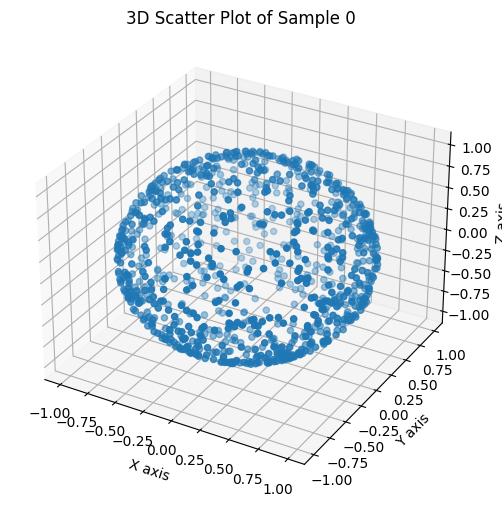

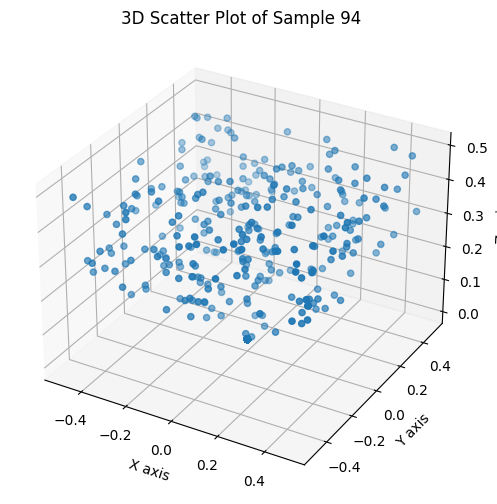

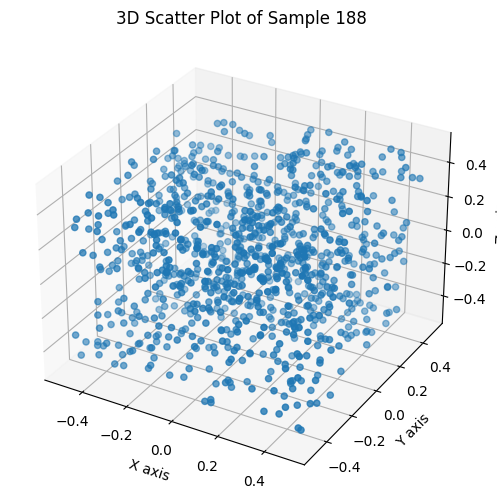

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_sample(data, index):
    """
    Visualize a single sample from the dataset in a 3D scatter plot.

    Parameters:
    data (numpy.ndarray): The dataset containing the samples (shape: [batch_size, num_points, num_dimensions]).
    index (int): The index of the sample to visualize.
    """
    if index >= len(data):
        print(f"Index {index} is out of bounds for dataset with length {len(data)}.")
        return

    sample = data[index]
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

    # Labels and titles
    ax.set_title(f"3D Scatter Plot of Sample {index}")
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.show()

# Example usage
visualize_sample(data, 0)  # Visualize a sphere sample
visualize_sample(data, batch_size // 3)  # Visualize a pyramid sample
visualize_sample(data, 2 * (batch_size // 3))  # Visualize a cube sample



In [10]:
data.shape

(283, 1000, 3)

In [13]:
data_tensor.shape

torch.Size([283, 1000, 3])

In [4]:
def test(model, test_tuple, num_class=3, use_cpu=True):
    mean_correct = []
    class_acc = np.zeros((num_class, 3))
    classifier = model.eval()

    for j, (points, target) in tqdm(enumerate(test_tuple), total=len(test_tuple)):

        if not use_cpu:
            points, target = points.cuda(), target.cuda()

        points = points.transpose(2, 1)
        pred, _ = classifier(points)
        pred_choice = pred.data.max(1)[1]

        for cat in np.unique(target.cpu()):
            classacc = pred_choice[target == cat].eq(target[target == cat].long().data).cpu().sum()
            class_acc[cat, 0] += classacc.item() / float(points[target == cat].size()[0])
            class_acc[cat, 1] += 1

        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))

    class_acc[:, 2] = class_acc[:, 0] / class_acc[:, 1]
    class_acc = np.mean(class_acc[:, 2])
    instance_acc = np.mean(mean_correct)

    return instance_acc, class_acc

In [5]:
# input size is (batch, num_points, dim)
# transposed input size is (batch, dim, num_points)

import provider

num_class = 3
use_cpu = True
optimizer = 'Adam'
decay_rate = 1e-4
learning_rate = 0.001
n_epochs = 1
use_normals = False
n_samples = len(X_train)
batch_size = 24

classifier = get_model(num_class, normal_channel=use_normals)
criterion = get_loss()

if optimizer == 'Adam':
    optimizer = torch.optim.Adam(
        classifier.parameters(),
        lr=learning_rate,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=decay_rate
    )
else:
    optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

start_epoch = 0
global_epoch = 0
global_step = 0
best_instance_acc = 0.0
best_class_acc = 0.0


for epoch in range(start_epoch, n_epochs):
    print('Epoch %d (%d/%s):' % (global_epoch + 1, epoch + 1, n_epochs))
    mean_correct = []
    classifier = classifier.train()

    for i in tqdm(range(0, n_samples, batch_size)):
        permutation = torch.randperm(n_samples)
        batch_indices = permutation[i:i + batch_size]
        optimizer.zero_grad()
        points, target = X_train[batch_indices], y_train[batch_indices]
        print("points shape", points.shape)
        points = provider.random_point_dropout(points)
        points[:, :, 0:3] = provider.random_scale_point_cloud(points[:, :, 0:3])
        points[:, :, 0:3] = provider.shift_point_cloud(points[:, :, 0:3])
        points = torch.Tensor(points)
        points = points.transpose(2, 1)
        print("points shape after transpose", points.shape)

        if not use_cpu:
            points, target = points.cuda(), target.cuda()

        pred, trans_feat = classifier(points)
        loss = criterion(pred, target, trans_feat)
        pred_choice = pred.data.max(1)[1]

        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))
        loss.backward()
        optimizer.step()
        global_step += 1

    train_instance_acc = np.mean(mean_correct)
    print('Train Instance Accuracy: %f' % train_instance_acc)

    test_tuple = [(X_test, y_test)]
    with torch.no_grad():
        instance_acc, class_acc = test(classifier.eval(), test_tuple, num_class=num_class, use_cpu=use_cpu)

        if (instance_acc >= best_instance_acc):
            best_instance_acc = instance_acc
            best_epoch = epoch + 1

        if (class_acc >= best_class_acc):
            best_class_acc = class_acc
        print('Test Instance Accuracy: %f, Class Accuracy: %f' % (instance_acc, class_acc))
        print('Best Instance Accuracy: %f, Class Accuracy: %f' % (best_instance_acc, best_class_acc))

        if (instance_acc >= best_instance_acc):
            print.info('Save model...')
            # savepath = str(checkpoints_dir) + '/best_model.pth'
            savepath = './best_model'
            print('Saving at %s' % savepath)
            state = {
                'epoch': best_epoch,
                'instance_acc': instance_acc,
                'class_acc': class_acc,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }
            torch.save(state, savepath)
        global_epoch += 1

print('End of training.')

radius_list:  [0.1, 0.2, 0.4]
radius_list:  [0.2, 0.4, 0.8]
Epoch 1 (1/1):


  0%|          | 0/9 [00:00<?, ?it/s]

points shape torch.Size([24, 1000, 3])


RuntimeError: unsupported operation: some elements of the input tensor and the written-to tensor refer to a single memory location. Please clone() the tensor before performing the operation.